In [70]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.cluster import KMeans

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading data
accepted = pd.read_csv('data/LC/Lending_Club_Accepted_2014_2018.csv')
rejected = pd.read_csv('data/LC/Lending_Club_Rejected_2014_2018.csv')

stripped_accepted = accepted[['loan_amnt', 'issue_d', 'title', 'dti', 'zip_code', 'addr_state', 'emp_length', 'policy_code']]
stripped_accepted['accepted'] = 1
rejected.rename(columns={'Amount_Requested': 'loan_amnt',
                         'Application_Date': 'date',
                         'Loan_Title': 'title',
                         'Risk_Score': 'risk_score',
                         'Debt_to_Income_Ratio': 'dti',
                         'Zip_Code': 'zip_code',
                         'State': 'state',
                         'Employment_Length': 'emp_length',
                         'Policy_Code': 'policy_code'}, inplace=True)
rejected.drop(columns='risk_score', inplace=True)
rejected['accepted'] = 0
stripped_accepted.rename(columns={'issue_d': 'date',
                                  'addr_state': 'state'}, inplace=True)
full_data = pd.concat([stripped_accepted, rejected])
full_data.head()

,loan_amnt,date,title,dti,zip_code,state,emp_length,policy_code,accepted
0,3600.0,Dec-2015,Debt consolidation,5.91,190xx,PA,10+ years,1.0,1
1,24700.0,Dec-2015,Business,16.06,577xx,SD,10+ years,1.0,1
2,20000.0,Dec-2015,NaN,10.78,605xx,IL,10+ years,1.0,1
3,35000.0,Dec-2015,Debt consolidation,17.06,076xx,NJ,10+ years,1.0,1
4,10400.0,Dec-2015,Major purchase,25.37,174xx,PA,3 years,1.0,1


In [3]:
# Cleaning loan titles
loan_titles = ['Debt Consolidation', 'Credit Card', 'Home', 'Car', 'Medical', 'Business', 'Other']
def clean_titles(full_data):
    full_data['title'] = full_data['title'].fillna('')
    full_data['title'] = full_data['title'].str.lower()
    full_data.loc[full_data['title'].str.contains('credit'), 'title'] = 'Credit Card'
    full_data.loc[full_data['title'].str.contains('cc'), 'title'] = 'Credit Card'
    full_data.loc[full_data['title'].str.contains('debt'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('consolidation'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('consolidate'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('payoff'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('pay off'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('refinance'), 'title'] = 'Debt Consolidation'
    full_data.loc[full_data['title'].str.contains('home'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('house'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('moving'), 'title'] = 'Home'
    full_data.loc[full_data['title'].str.contains('car'), 'title'] = 'Car'
    full_data.loc[full_data['title'].str.contains('medical'), 'title'] = 'Medical'
    full_data.loc[full_data['title'].str.contains('business'), 'title'] = 'Business'
    full_data.loc[~full_data['title'].isin(loan_titles), 'title'] = 'Other'
    return full_data

In [4]:
full_data = clean_titles(full_data)

In [5]:
urban_rural_states = pd.read_csv('data/census_data/2010_urban_rural_states.csv', skiprows=1)
state_abbr = pd.read_csv('data/census_data/state_abbr.csv')
urban_rural_states['total_pop'] = urban_rural_states['Total!!Rural'] + urban_rural_states['Total!!Urban']
urban_rural_states['rural_prop'] = urban_rural_states['Total!!Rural'] / urban_rural_states['total_pop']
urban_rural_states = urban_rural_states.merge(state_abbr, left_on='Geographic Area Name', right_on='State')
urban_rural_states = urban_rural_states.rename(columns={'Code': 'state'})
urban_rural_states = urban_rural_states[['state', 'rural_prop', 'total_pop']]
urban_rural_states.head(10)

,state,rural_prop,total_pop
0,AL,0.416524,2171853
1,AK,0.403881,306967
2,AZ,0.115668,2844526
3,AR,0.452568,1316299
4,CA,0.063259,13680081
5,CO,0.168969,2212898
6,CT,0.120540,1487891
7,DE,0.164515,405885
8,DC,0.000000,296719
9,FL,0.088944,8989580


In [6]:
relevant_cols = ['title', 'emp_title', 'emp_length', 'fico_range_low', 'fico_range_high',
                 'zip_code', 'addr_state', 'loan_amnt', 'grade', 'dti', 'term', 'int_rate',
                 'home_ownership', 'issue_d']
filtered_accepted = accepted[relevant_cols]
filtered_accepted['fico'] = (filtered_accepted['fico_range_low'] + filtered_accepted['fico_range_high']) / 2
filtered_accepted.drop(columns=['fico_range_low', 'fico_range_high'], inplace=True)
filtered_accepted = clean_titles(filtered_accepted)
filtered_accepted = filtered_accepted.rename(columns={'addr_state': 'state'})
filtered_accepted = filtered_accepted.merge(urban_rural_states, on='state')
filtered_accepted['issue_d'] = pd.to_datetime(filtered_accepted['issue_d']).dt.strftime('%m-%Y')
filtered_accepted.head()

,title,emp_title,emp_length,zip_code,state,loan_amnt,grade,dti,term,int_rate,home_ownership,issue_d,fico,rural_prop,total_pop
0,Debt Consolidation,leadman,10+ years,190xx,PA,3600.0,C,5.91,36 months,13.99,MORTGAGE,12-2015,677.0,0.224589,5567315
1,Other,Contract Specialist,3 years,174xx,PA,10400.0,F,25.37,60 months,22.45,MORTGAGE,12-2015,697.0,0.224589,5567315
2,Credit Card,SERVICE MANAGER,6 years,160xx,PA,10000.0,A,13.07,36 months,6.49,RENT,12-2015,687.0,0.224589,5567315
3,Debt Consolidation,Mechanic,10+ years,172xx,PA,18000.0,A,15.56,36 months,7.91,MORTGAGE,12-2015,742.0,0.224589,5567315
4,Debt Consolidation,Graduate Student,1 year,191xx,PA,3600.0,C,26.45,36 months,13.44,RENT,12-2015,712.0,0.224589,5567315


In [7]:
pre_2016 = filtered_accepted[filtered_accepted['issue_d'] < '05-2016']
post_2016 = filtered_accepted[filtered_accepted['issue_d'] > '05-2016']

In [8]:
full_data['date'] = pd.to_datetime(full_data['date']).dt.strftime('%m-%Y')
full_data_pre_2016 = full_data[full_data['date'] < '05-2016']
full_data_post_2016 = full_data[full_data['date'] > '05-2016']

In [9]:
filtered_accepted = filtered_accepted[~filtered_accepted['dti'].isna()]

In [10]:
filtered_accepted = filtered_accepted.join(pd.get_dummies(filtered_accepted['grade'], drop_first=True))

In [11]:
# int_rate ~ grade, fico, dti
X, y = sm.add_constant(filtered_accepted[['B', 'C', 'D', 'E', 'F', 'G', 'fico', 'dti']]), filtered_accepted['int_rate']
ols = sm.OLS(y, X)
ols_results = ols.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.755e+06
Date:                Fri, 22 Jul 2022   Prob (F-statistic):               0.00
Time:                        18:04:11   Log-Likelihood:            -3.5805e+06
No. Observations:             2028241   AIC:                         7.161e+06
Df Residuals:                 2028232   BIC:                         7.161e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3610      0.025    375.877      0.0

In [42]:
filtered_accepted['predicted_int_rate'] = ols_results.predict(X)
filtered_accepted['int_rate_residual'] = filtered_accepted['int_rate'] - filtered_accepted['predicted_int_rate']
plot_df = filtered_accepted.groupby('state').mean()['int_rate_residual'].reset_index()
plot_df = plot_df[~plot_df['state'].isin(['IA'])]

fig = px.choropleth(plot_df,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='int_rate_residual',
                    color_continuous_scale="PuBu")
fig.show()

In [39]:
# int_rate ~ grade, fico, dti, rural_prop
X, y = sm.add_constant(filtered_accepted[['B', 'C', 'D', 'E', 'F', 'G', 'fico', 'dti', 'rural_prop']]), filtered_accepted['int_rate']
ols = sm.OLS(y, X)
ols_results = ols.fit()
print(ols_results.summary())

                            OLS Regression Results                            
Dep. Variable:               int_rate   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.449e+06
Date:                Fri, 22 Jul 2022   Prob (F-statistic):               0.00
Time:                        15:47:14   Log-Likelihood:            -3.5804e+06
No. Observations:             2028241   AIC:                         7.161e+06
Df Residuals:                 2028231   BIC:                         7.161e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3663      0.025    375.677      0.0

In [57]:
# Clustering
X = filtered_accepted[['B', 'C', 'D', 'E', 'F', 'G', 'fico', 'dti']]
kmeans = KMeans()
kmeans.fit(X)

KMeans()

In [58]:
filtered_accepted['cluster'] = kmeans.predict(X)

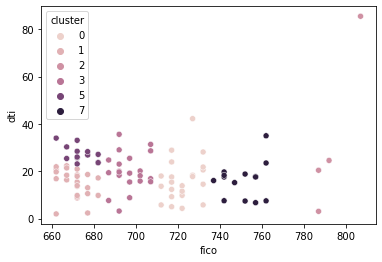

In [59]:
sns.scatterplot(data=filtered_accepted.sample(100), x='fico', y='dti', hue='cluster')

In [21]:
filtered_accepted.columns

Index(['title', 'emp_title', 'emp_length', 'zip_code', 'state', 'loan_amnt',
       'grade', 'dti', 'term', 'int_rate', 'home_ownership', 'issue_d', 'fico',
       'rural_prop', 'total_pop', 'B', 'C', 'D', 'E', 'F', 'G'],
      dtype='object')

In [32]:
clustering_cols = ['title', 'loan_amnt', 'grade', 'dti', 'term', 'home_ownership', 'fico']
for col in clustering_cols:
    filtered_accepted = filtered_accepted[~filtered_accepted[col].isna()]

filtered_accepted[clustering_cols]

,title,loan_amnt,grade,dti,term,home_ownership,fico
0,Debt Consolidation,3600.0,C,5.91,36 months,MORTGAGE,677.0
1,Other,10400.0,F,25.37,60 months,MORTGAGE,697.0
2,Credit Card,10000.0,A,13.07,36 months,RENT,687.0
3,Debt Consolidation,18000.0,A,15.56,36 months,MORTGAGE,742.0
4,Debt Consolidation,3600.0,C,26.45,36 months,RENT,712.0
...,...,...,...,...,...,...,...
2029946,Debt Consolidation,10000.0,C,24.68,36 months,MORTGAGE,677.0
2029947,Debt Consolidation,26500.0,C,16.66,60 months,RENT,707.0
2029948,Debt Consolidation,12000.0,C,26.91,36 months,RENT,672.0
2029950,Debt Consolidation,16000.0,C,25.69,36 months,RENT,667.0


In [33]:
# Remove outliers
for col in ['loan_amnt', 'dti']:
    q_low = filtered_accepted[col].quantile(0.025)
    q_high = filtered_accepted[col].quantile(0.975)
    filtered_accepted = filtered_accepted[(filtered_accepted[col] > q_low) & (filtered_accepted[col] < q_high)]

In [67]:
filtered_accepted['grade'] = pd.Categorical(filtered_accepted['grade'])
filtered_accepted['grade_numeric'] = filtered_accepted['grade'].cat.codes

In [144]:
from sklearn.preprocessing import StandardScaler
clustering_df = filtered_accepted[['grade_numeric', 'dti', 'fico']]
scaler = StandardScaler()
clustering_df = pd.DataFrame(scaler.fit_transform(clustering_df), columns=['grade_numeric', 'dti', 'fico'])
clustering_df.head()

,grade_numeric,dti,fico
0,0.319730,-1.729308,-0.679043
1,2.750674,0.951419,-0.054222
2,-1.300899,-0.742977,-0.366632
3,-1.300899,-0.399965,1.351624
4,0.319730,1.100195,0.414393


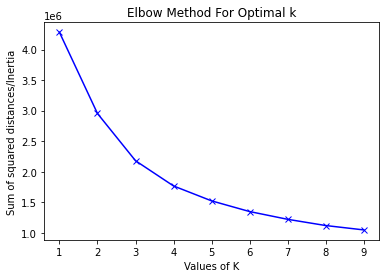

In [145]:
Sum_of_squared_distances = []
K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(clustering_df)
    Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances, 'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()

In [146]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(clustering_df)
filtered_accepted['cluster'] = kmeans.predict(clustering_df)

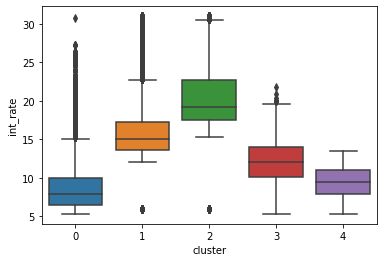

In [157]:
sns.boxplot(data=filtered_accepted, x='cluster', y='int_rate')

In [148]:
plot_df = pd.concat([filtered_accepted[filtered_accepted['cluster'] == 0].grade.value_counts(normalize=True).reset_index(),
                     filtered_accepted[filtered_accepted['cluster'] == 1].grade.value_counts(normalize=True).reset_index(),
                     filtered_accepted[filtered_accepted['cluster'] == 2].grade.value_counts(normalize=True).reset_index(),
                     filtered_accepted[filtered_accepted['cluster'] == 3].grade.value_counts(normalize=True).reset_index(),
                     filtered_accepted[filtered_accepted['cluster'] == 4].grade.value_counts(normalize=True).reset_index()])

cluster_names = [0]*7 + [1]*7 + [2]*7 + [3]*7 + [4]*7

plot_df['cluster'] = cluster_names
plot_df.rename(columns={'grade': 'proportion_of_loans', 'index': 'grade'}, inplace=True)
plot_df.head()

,grade,proportion_of_loans,cluster
0,A,0.625870,0
1,B,0.281233,0
2,C,0.083347,0
3,D,0.008672,0
4,E,0.000850,0


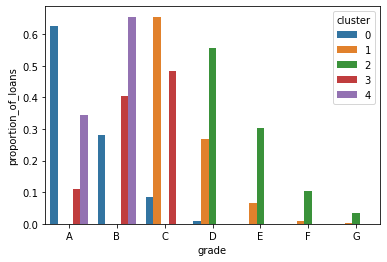

In [149]:
sns.barplot(data=plot_df, x='grade', y='proportion_of_loans', hue='cluster')

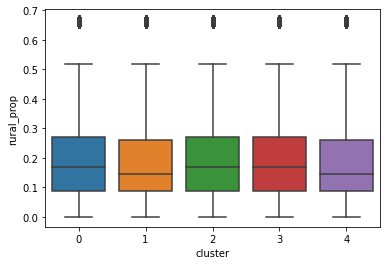

In [158]:
sns.boxplot(data=filtered_accepted, x='cluster', y='rural_prop')

In [180]:
# Within cluster 2
cluster_2 = filtered_accepted[filtered_accepted['cluster'] == 2]
cluster_2.groupby('state').mean()['int_rate'].sort_values()

state
WV    19.711748
KS    20.038597
WY    20.070473
AK    20.143447
SD    20.229606
OK    20.231388
TN    20.245887
LA    20.249898
UT    20.250618
MO    20.280373
PA    20.294078
MT    20.296276
NM    20.300584
IN    20.308976
TX    20.313426
AR    20.315330
WI    20.324652
OH    20.333327
NH    20.339954
MS    20.358868
NV    20.371180
VT    20.377628
AL    20.395698
SC    20.417543
MN    20.421405
NC    20.425720
KY    20.429072
AZ    20.450828
WA    20.464774
OR    20.472072
CO    20.474896
IL    20.481895
FL    20.486047
VA    20.498272
HI    20.500130
CA    20.512747
GA    20.518798
DC    20.522925
MI    20.541508
MD    20.543189
NJ    20.549627
RI    20.584779
ND    20.605673
DE    20.658502
ME    20.664149
MA    20.694473
NY    20.697021
CT    20.700542
NE    20.885535
ID    21.195491
Name: int_rate, dtype: float64

In [177]:
# Within cluster 2
plot_df = filtered_accepted[filtered_accepted['cluster'] == 1]
plot_df = (plot_df[plot_df['state'] != 'IA'].groupby('state').count()['cluster'] / filtered_accepted[filtered_accepted['state'] != 'IA'].groupby('state').count()['cluster'].values).reset_index()
plot_df['cluster_4_proportion_of_state_population'] = plot_df['cluster']

fig = px.choropleth(plot_df,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='cluster',
                    color_continuous_scale="PuBu")
fig.show()

In [174]:
# Within cluster 2
plot_df = filtered_accepted[filtered_accepted['cluster'] == 2]
plot_df = (plot_df.groupby('state').count()['cluster'] / filtered_accepted[filtered_accepted['state'] != 'IA'].groupby('state').count()['cluster'].values).reset_index()
plot_df['cluster_2_proportion_of_state_population'] = plot_df['cluster']

fig = px.choropleth(plot_df,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='cluster_2_proportion_of_state_population',
                    color_continuous_scale="PuBu")
fig.show()

In [172]:
# Within cluster 2
plot_df = filtered_accepted[filtered_accepted['cluster'] == 0]
plot_df = (plot_df.groupby('state').count()['cluster'] / filtered_accepted[filtered_accepted['state'] != 'IA'].groupby('state').count()['cluster'].values).reset_index()

fig = px.choropleth(plot_df,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='cluster',
                    color_continuous_scale="PuBu")
fig.show()

In [167]:
fig = px.choropleth(filtered_accepted.groupby('state').count().reset_index(),
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='title',
                    color_continuous_scale="PuBu")
fig.show()

In [166]:
filtered_accepted['rural_prop'].describe()

count    1.428086e+06
mean     1.861239e-01
std      1.135613e-01
min      0.000000e+00
25%      8.894442e-02
50%      1.689694e-01
75%      2.694194e-01
max      6.696182e-01
Name: rural_prop, dtype: float64

In [165]:
filtered_accepted['cluster'].value_counts()

3    368616
1    330393
4    327152
0    218868
2    183057
Name: cluster, dtype: int64